In [1]:
import pandas as pd

df = pd.read_csv("../data/df_indi_works.csv", index_col=0)
regions = pd.read_csv('ENS - Cultural Index - Countries Databases - region_level.csv')
regions = regions[regions['level'] == 2]
regions = set(regions['region_name'])
df = df[df['region_name'].isin(regions)]
df["century"] = df["decade"].round(-2)
df.head(n=10)

,individual_wikidata_id,cultural_score,birthyear,decade,individual_name,region_code,region_name,century
2,Q100035,2.0,1800.0,1800,Franz von Gaudy,re_german_world,German world,1800
6,Q1000899,1.0,1840.0,1840,Leó Fessler,re_german_world,German world,1800
8,Q1001063,2.0,1848.0,1850,Olga Fialka,re_eastern_europe,Eastern Europe,1800
9,Q1001063,2.0,1848.0,1850,Olga Fialka,re_central_europe,Central Europe,1800
12,Q100116,2.0,1654.0,1650,Christoph Weigel the Elder,re_german_world,German world,1600
16,Q100156894,1.0,1817.0,1820,Jacob Christian Gottschalk,re_nordic_countries,Nordic countries,1800
20,Q100242,16.0,1775.0,1780,Johann Jakob Dorner the Younger,re_german_world,German world,1800
24,Q100252598,2.0,1795.0,1800,Alexis Durand,re_france,France,1800
28,Q100269025,1.0,1849.0,1850,Giovanni Avolio,re_italy,Italy,1800
32,Q100277,1.0,1843.0,1840,Moritz Fleischer,re_german_world,German world,1800


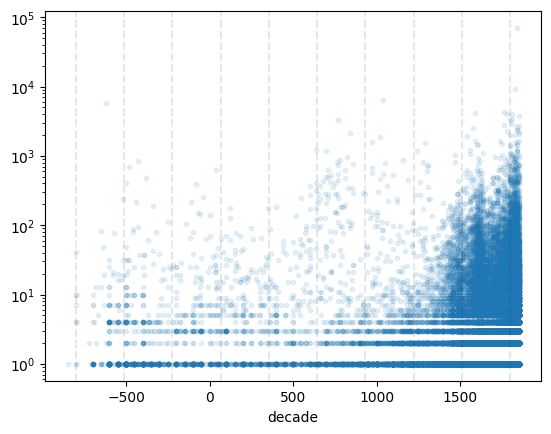

In [2]:
import matplotlib.pyplot as plt
import numpy as np

num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)

fig, ax = plt.subplots()
(df.groupby(["decade", "individual_wikidata_id"])["cultural_score"].sum() + 1).droplevel(
    level="individual_wikidata_id").plot(style=".", alpha=0.1, logy=True, ax=ax)

for knot in knots:
    ax.axvline(knot, color="0.1", alpha=0.1, ls="--")

In [3]:
df['count'] = df['cultural_score']
df_m = df.copy()
df_m = df_m[df_m['count'].isin({0, 1, 2})]
df_m['y'] = df_m['count'].map({0: 0, 1: 0, 2: 1})
df_m.sample(10)

,individual_wikidata_id,cultural_score,birthyear,decade,individual_name,region_code,region_name,century,count,y
27765,Q17344751,1.0,1847.0,1850,Shākir Khūrī,re_arabic_world,Arabic world,1800,1.0,0
545180,Q11928160,0.0,1719.0,1720,Joaquín Martínez de Oxinagas,re_spain,Spain,1700,0.0,0
190998,Q55847940,0.0,1735.0,1740,Theodor Graf von Morawitzky,re_german_world,German world,1700,0.0,0
504760,Q1707011,0.0,1704.0,1700,Joseph Franz,re_german_world,German world,1700,0.0,0
569542,Q3165912,0.0,1768.0,1770,Jean François Thurot,re_france,France,1800,0.0,0
488214,Q55051870,0.0,1663.0,1660,Johann Georg Hoyer,re_german_world,German world,1700,0.0,0
431102,Q19856944,0.0,1808.0,1810,Aristide Letorzec,re_france,France,1800,0.0,0
259973,Q96126315,0.0,1754.0,1750,Stanisław Piątkowski,re_eastern_europe,Eastern Europe,1800,0.0,0
110429,Q57786982,2.0,1797.0,1800,Aimable Le Bot,re_france,France,1800,2.0,1
365125,Q11727328,0.0,1742.0,1740,Joachim Otto Zygmunt Kalnassy,re_eastern_europe,Eastern Europe,1700,0.0,0


## Global B-Spline Analysis

In [4]:
import bambi as bmb
import arviz as az

iknots = knots[1:-1]

sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
}

m_splines = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True)', sample, family='bernoulli', priors=priors)
m_splines

       Formula: y ~ bs(decade, knots=iknots, intercept=True)
        Family: bernoulli
          Link: p = logit
  Observations: 161649
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            bs(decade, knots = iknots, intercept = True) ~ Normal(mu: 0.0, sigma: 5.0)

In [96]:
p_splines = m_splines.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(p_splines)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(decade, knots = iknots, intercept = True)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2666 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.527,1.480,-5.104,0.365,0.067,0.047,490.0,563.0,1.01
"bs(decade, knots = iknots, intercept = True)[0]",0.255,1.840,-3.353,3.444,0.072,0.051,651.0,988.0,1.01
"bs(decade, knots = iknots, intercept = True)[1]",1.226,1.623,-1.821,4.212,0.068,0.048,574.0,864.0,1.00
"bs(decade, knots = iknots, intercept = True)[2]",-1.114,1.562,-4.110,1.676,0.067,0.049,537.0,723.0,1.00
"bs(decade, knots = iknots, intercept = True)[3]",-0.268,1.519,-3.193,2.446,0.067,0.047,516.0,659.0,1.00
"bs(decade, knots = iknots, intercept = True)[4]",0.187,1.523,-2.630,3.026,0.068,0.048,507.0,647.0,1.01
"bs(decade, knots = iknots, intercept = True)[5]",0.888,1.513,-2.000,3.579,0.067,0.047,516.0,656.0,1.01
"bs(decade, knots = iknots, intercept = True)[6]",-0.058,1.509,-2.967,2.669,0.067,0.047,507.0,606.0,1.01
"bs(decade, knots = iknots, intercept = True)[7]",0.085,1.511,-2.826,2.748,0.067,0.047,508.0,603.0,1.01
"bs(decade, knots = iknots, intercept = True)[8]",0.143,1.487,-2.759,2.771,0.067,0.047,495.0,549.0,1.01


In [5]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

def plot_predictions(data, idata, model, region=None, ax=None, plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    if region is not None:
        data = data[data["region_name"] == region]
        new_data["region_name"] = [region] * 500
    new_data["decade"] = np.linspace(data["decade"].min(), data["decade"].max(), num=500)
    new_data = pd.DataFrame(new_data)

    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    y_hat = posterior_stacked["y_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(new_data["decade"], y_hat_mean, color=color, label=region)

    # Plot credibility bands
    ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="p(n_obs=2)")

Plot the global probability of observing a producer twice in the dataset, i.e. $p(n_{\text{obs}} = 2)$:

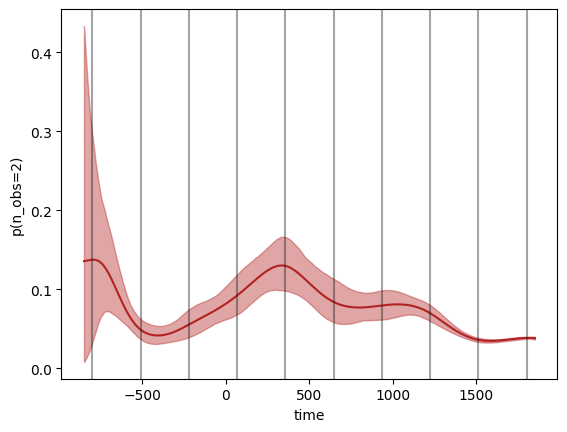

In [100]:
plot_predictions(sample, p_splines, m_splines);

## Global Spline Analysis with Varying Intercepts for Region

In [130]:
sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

m_splines_vi = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vi

       Formula: y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)
        Family: bernoulli
          Link: p = logit
  Observations: 161649
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            bs(decade, knots = iknots, intercept = True) ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.0))

In [131]:
p_splines_vi = m_splines_vi.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(p_splines_vi)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(decade, knots = iknots, intercept = True), 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4607 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.522,1.454,-5.254,0.190,0.054,0.039,719.0,1168.0,1.01
"bs(decade, knots = iknots, intercept = True)[0]",0.544,1.812,-3.072,3.676,0.056,0.040,1043.0,1803.0,1.00
"bs(decade, knots = iknots, intercept = True)[1]",1.507,1.619,-1.381,4.624,0.056,0.040,824.0,1405.0,1.01
"bs(decade, knots = iknots, intercept = True)[2]",-0.829,1.512,-3.575,2.081,0.055,0.039,766.0,1296.0,1.01
"bs(decade, knots = iknots, intercept = True)[3]",-0.073,1.515,-2.799,2.844,0.055,0.039,766.0,1367.0,1.01
"bs(decade, knots = iknots, intercept = True)[4]",0.202,1.485,-2.602,2.919,0.055,0.039,746.0,1297.0,1.01
"bs(decade, knots = iknots, intercept = True)[5]",0.889,1.497,-1.933,3.606,0.055,0.039,734.0,1319.0,1.01
"bs(decade, knots = iknots, intercept = True)[6]",-0.070,1.490,-2.861,2.677,0.054,0.038,759.0,1314.0,1.01
"bs(decade, knots = iknots, intercept = True)[7]",-0.044,1.482,-2.640,2.829,0.055,0.039,726.0,1302.0,1.01
"bs(decade, knots = iknots, intercept = True)[8]",0.032,1.462,-2.845,2.590,0.055,0.039,721.0,1171.0,1.01


## Varying Splines Analysis on Regions

In [6]:
sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "bs(decade, knots = iknots, intercept = True)|region_name": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.5))
}

m_splines_vs = bmb.Model(
    'y ~ 1 + (bs(decade, knots=iknots, intercept=True)|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vs

       Formula: y ~ 1 + (bs(decade, knots=iknots, intercept=True)|region_name)
        Family: bernoulli
          Link: p = logit
  Observations: 161649
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
            bs(decade, knots = iknots, intercept = True)|region_name ~ Normal(mu: 0.0, sigma:
                HalfNormal(sigma: 2.5))

In [7]:
p_splines_vs = m_splines_vs.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro')  # important to run faster and sample more efficiently
az.summary(p_splines_vs)

Modeling the probability that y==1


Compiling...
Compilation time =  0:00:03.977827
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:51:21.242365
Transforming variables...
Transformation time =  0:00:00.115329


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.107,0.107,-3.300,-2.897,0.004,0.003,556.0,1329.0,1.01
1|region_name_sigma,0.186,0.108,0.000,0.360,0.005,0.004,471.0,947.0,1.01
"bs(decade, knots = iknots, intercept = True)|region_name_sigma[0]",1.364,1.066,0.001,3.183,0.021,0.015,2050.0,1758.0,1.00
"bs(decade, knots = iknots, intercept = True)|region_name_sigma[1]",1.750,0.945,0.074,3.521,0.024,0.017,1333.0,1251.0,1.00
"bs(decade, knots = iknots, intercept = True)|region_name_sigma[2]",0.615,0.549,0.001,1.627,0.013,0.009,1694.0,2261.0,1.00
...,...,...,...,...,...,...,...,...,...
"bs(decade, knots = iknots, intercept = True)|region_name[11, Persian world]",-0.438,0.413,-1.232,0.277,0.012,0.009,1252.0,2215.0,1.00
"bs(decade, knots = iknots, intercept = True)|region_name[11, Portugal]",-0.227,0.300,-0.785,0.314,0.007,0.005,1758.0,2408.0,1.00
"bs(decade, knots = iknots, intercept = True)|region_name[11, Slav world]",-0.364,0.237,-0.780,0.100,0.008,0.006,820.0,1484.0,1.00
"bs(decade, knots = iknots, intercept = True)|region_name[11, Spain]",-0.074,0.198,-0.473,0.279,0.005,0.004,1539.0,2038.0,1.00


Plot the regional probability of observing a producer twice in the dataset over time, i.e. 𝑝(𝑛obs=2):

Text(0.5, 0.01, 'time')

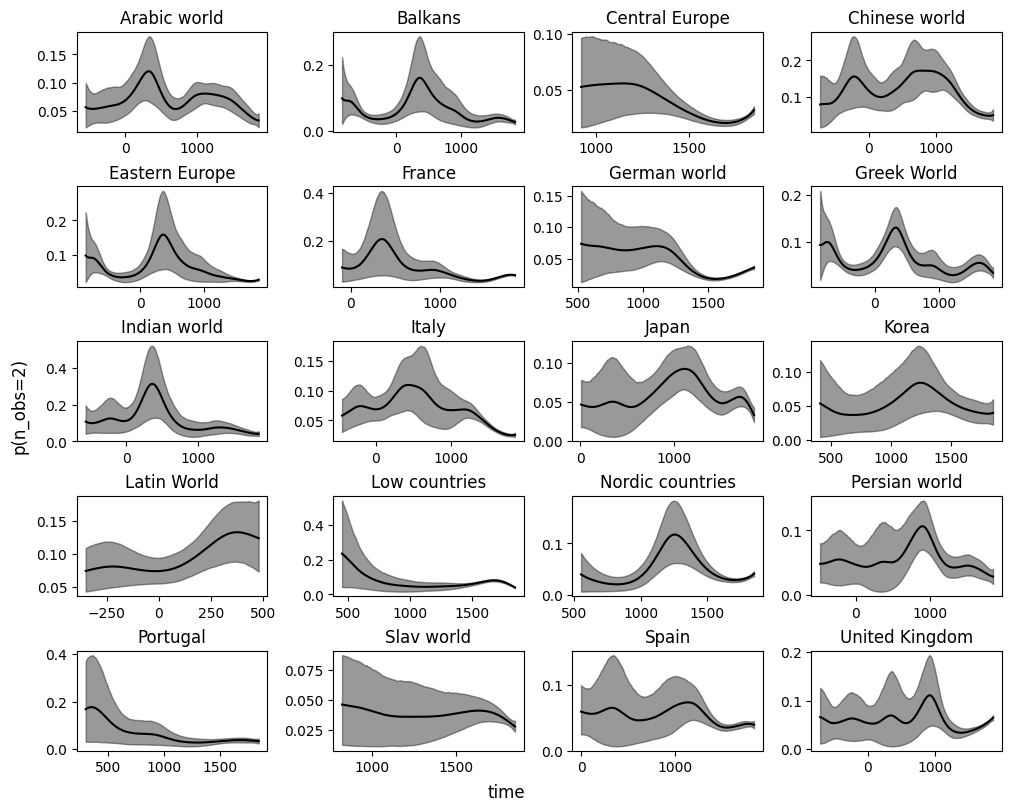

In [10]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

for i, region in enumerate(sorted(df_m["region_name"].unique())):
    plot_predictions(
        sample, p_splines_vs, m_splines_vs, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")

fig.supylabel('p(n_obs=2)')
fig.supxlabel('time')

In [226]:
def plot_estimations(data, obs_data, idata, model, region=None, ax=None, logy=False, 
                     plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    data = data[data["region_name"] == region]
    obs_data = obs_data[obs_data["region_name"] == region]   
    
    new_data["decade"] = data["decade"].values 
    new_data["region_name"] = [region] * len(data["decade"].values)
    
    new_data = pd.DataFrame(new_data)
    
    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    p = posterior_stacked["y_mean"].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))

    decades = np.array(sorted(data["decade"].unique()))
    
    N_est = np.zeros((len(decades), f0.shape[1]))
    unseen = np.zeros((len(decades), f0.shape[1]))
    
    for i, decade in enumerate(decades):
        n_obs_di = data.loc[data["decade"] == decade, "individual_wikidata_id"].nunique()
        mask = (new_data["decade"] == decade).astype(int).values[:, None]
        f0_di = (f0 * mask).sum(0)
        S_di = n_obs_di + f0_di
        N_est[i] = S_di
        unseen[i] = f0_di

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(N_est, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=region)
    
    df[df["region_name"] == region].groupby("decade")["individual_wikidata_id"].count().plot(
        ax=ax, ls="--", color="red")
    
    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")
    
    return unseen, N_est, hdi_data, decades

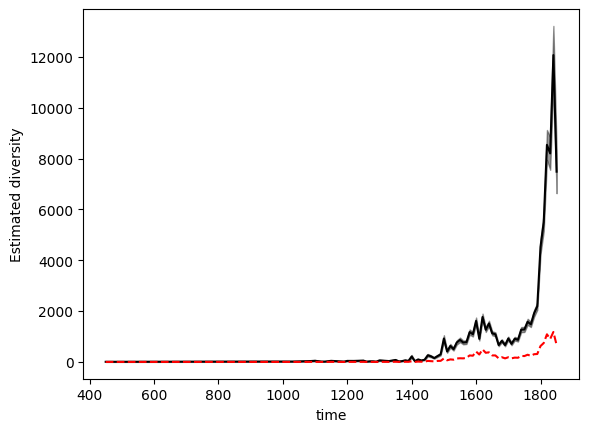

In [219]:
plot_estimations(
    sample, df, p_splines_vs, m_splines_vs, "Low countries", color="k", plot_knot_lines=False);

Text(0.5, 0.01, 'time')

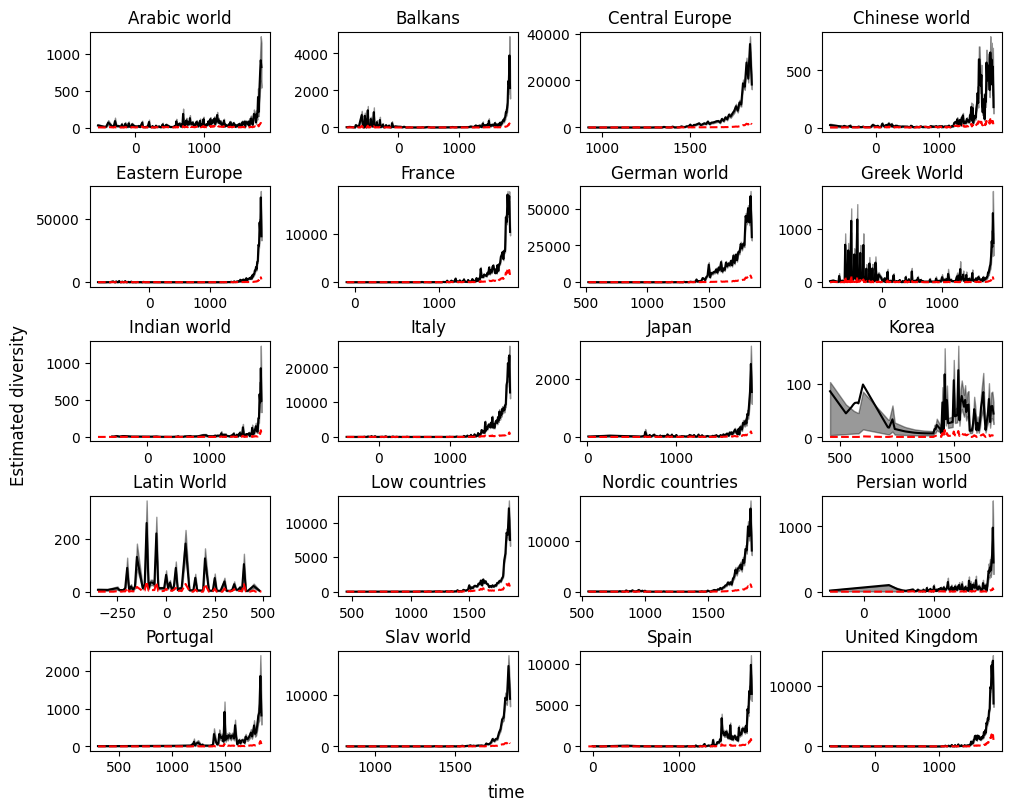

In [227]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

results = {}
for i, region in enumerate(sorted(df_m["region_name"].unique())):
    f0, N_est, hdi, decades = plot_estimations(
        sample, df, p_splines_vs, m_splines_vs, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")
    results[region] = f0, N_est, hdi, decades

fig.supylabel('Estimated diversity')
fig.supxlabel('time')

In [229]:
def plot_trend(decades, N_est, hdi_data, color="C0", label=None, ax=None, logy=False, figsize=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=label)

    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")

    return ax

(1200.0, 1900.0)

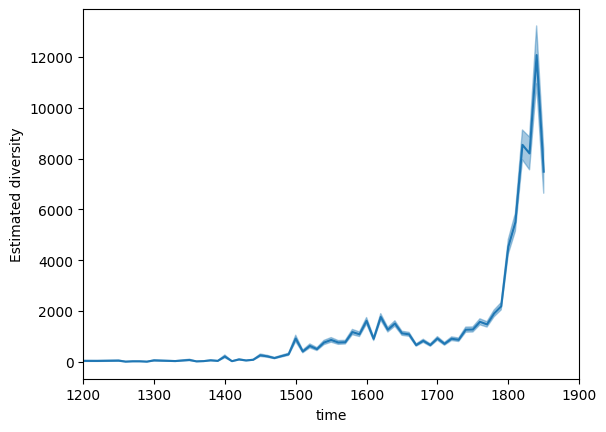

In [232]:
f0, N_est, hdi, decades = results["Low countries"]

ax = plot_trend(decades, N_est, hdi, label="Low countries")
ax.set_xlim(1200, 1900)

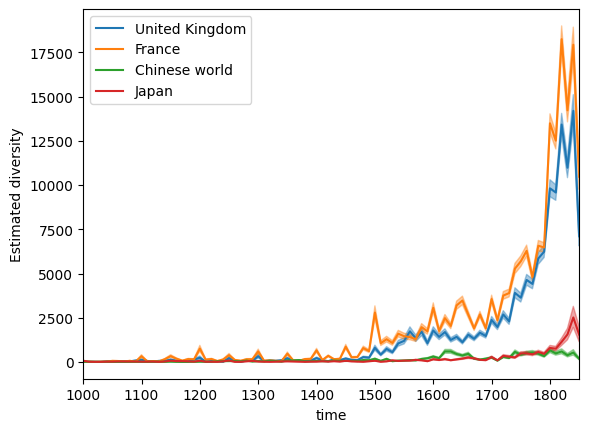

In [239]:
regions = "United Kingdom", "France", "Chinese world", "Japan"

fig, ax = plt.subplots()
for i, region in enumerate(regions):
    f0, N_est, hdi, decades = results[region]
    ax = plot_trend(decades, N_est, hdi, color=f"C{i}", logy=False, label=region, ax=ax)
ax.set_xlim(1000, 1850)
ax.legend()